## Setup

In [1]:
import tensorflow as tf

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

tf.__version__

'2.2.0'

### Retrieve the images

In [4]:
import pathlib

data_dir = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    fname='flower_photos',
    untar=True
)

data_dir = pathlib.Path(data_dir)
data_dir

228818944/228813984 [==============================] - 34s 0us/step


PosixPath('/home/nxhuy/.keras/datasets/flower_photos')

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [6]:
CLASS_NAMES = np.array(
    [item.name for item in data_dir.glob('*') if item.name != 'LICENSE.txt']
)
CLASS_NAMES

array(['sunflowers', 'daisy', 'dandelion', 'roses', 'tulips'],
      dtype='<U10')

In [7]:
roses = list(data_dir.glob('roses/*'))
roses

[PosixPath('/home/nxhuy/.keras/datasets/flower_photos/roses/7865295712_bcc94d120c.jpg'),
 PosixPath('/home/nxhuy/.keras/datasets/flower_photos/roses/15190665092_5c1c37a066_m.jpg'),
 PosixPath('/home/nxhuy/.keras/datasets/flower_photos/roses/17302463621_d82be11f01_n.jpg'),
 PosixPath('/home/nxhuy/.keras/datasets/flower_photos/roses/12243068283_ee4c2683e2_n.jpg'),
 PosixPath('/home/nxhuy/.keras/datasets/flower_photos/roses/4735314389_94fe1b2a9f_n.jpg'),
 PosixPath('/home/nxhuy/.keras/datasets/flower_photos/roses/2973256732_1926295f35.jpg'),
 PosixPath('/home/nxhuy/.keras/datasets/flower_photos/roses/5777669976_a205f61e5b.jpg'),
 PosixPath('/home/nxhuy/.keras/datasets/flower_photos/roses/5402157745_a384f0583d_n.jpg'),
 PosixPath('/home/nxhuy/.keras/datasets/flower_photos/roses/8667101118_87ea757b15.jpg'),
 PosixPath('/home/nxhuy/.keras/datasets/flower_photos/roses/3624546109_8eb98f0cdb.jpg'),
 PosixPath('/home/nxhuy/.keras/datasets/flower_photos/roses/3465443774_6b0c75a3b1_n.jpg'),
 Posix

In [9]:
len(roses)

641

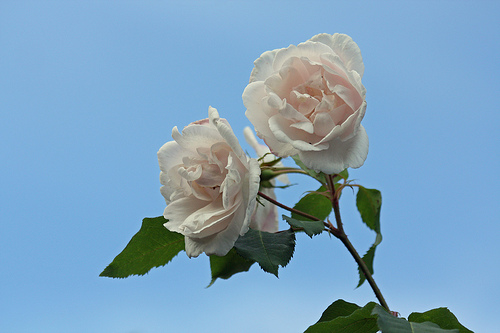

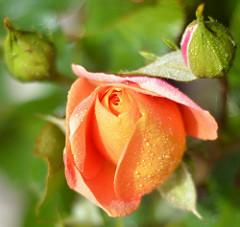

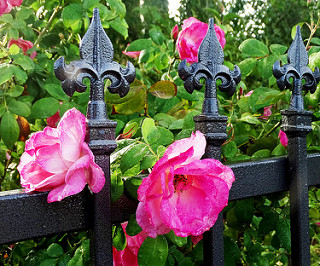

In [8]:
for image_path in roses[:3]:
    display.display(Image.open(image_path))

## Load using `keras.preprocessing`

A simple way to load images is to use `tf.keras.preprocessing`.

In [10]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [11]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [12]:
train_data_gen = image_generator.flow_from_directory(
    directory=str(data_dir),
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    classes=list(CLASS_NAMES)
)

Found 3670 images belonging to 5 classes.


In [13]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title()),
        plt.axis('off')

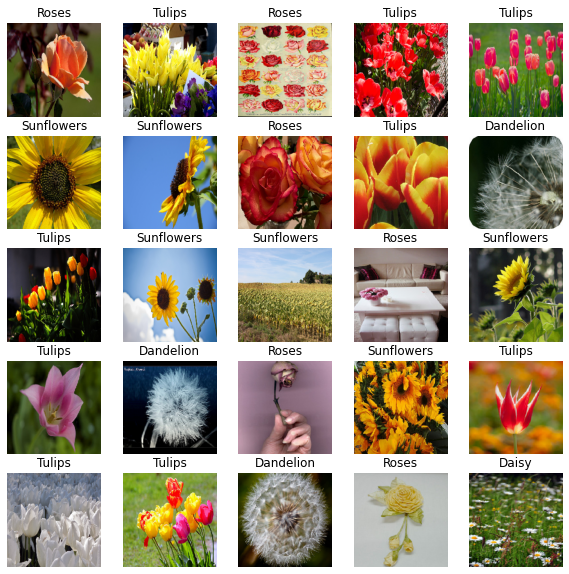

In [14]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [17]:
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 5))

`label_batch` contains the one-hot encoding vectors.

## Load using `tf.data`

In [24]:
CLASS_NAMES

array(['sunflowers', 'daisy', 'dandelion', 'roses', 'tulips'],
      dtype='<U10')

In [20]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [21]:
for f in list_ds.take(5):
    print(f.numpy())

b'/home/nxhuy/.keras/datasets/flower_photos/dandelion/5727534342_419604c177_n.jpg'
b'/home/nxhuy/.keras/datasets/flower_photos/daisy/18203367608_07a04e98a4_n.jpg'
b'/home/nxhuy/.keras/datasets/flower_photos/dandelion/16691236594_4287cea9d6_n.jpg'
b'/home/nxhuy/.keras/datasets/flower_photos/dandelion/3419176626_512811d3ff.jpg'
b'/home/nxhuy/.keras/datasets/flower_photos/tulips/13999392173_b1411f8b23_n.jpg'


In [23]:
tf.strings.split(b'/home/nxhuy/.keras/datasets/flower_photos/dandelion/5727534342_419604c177_n.jpg', os.path.sep)

<tf.Tensor: shape=(8,), dtype=string, numpy=
array([b'', b'home', b'nxhuy', b'.keras', b'datasets', b'flower_photos',
       b'dandelion', b'5727534342_419604c177_n.jpg'], dtype=object)>

In [22]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES

In [25]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

In [26]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [27]:
AUTOTUNE

-1

In [29]:
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [30]:
for image, label in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False  True False False False]


### Basice methods for training

To train a model with this dataset you will want the data:
- To be well shuffled.
- To be batched.
- Batches to be available as soon as possible.

These features can be easily added using the `tf.data` api.

In [31]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
            
    ds = ds.shuffle(shuffle_buffer_size)
    
    ds = ds.repeat()
    
    ds = ds.batch(BATCH_SIZE)
    
    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

In [32]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

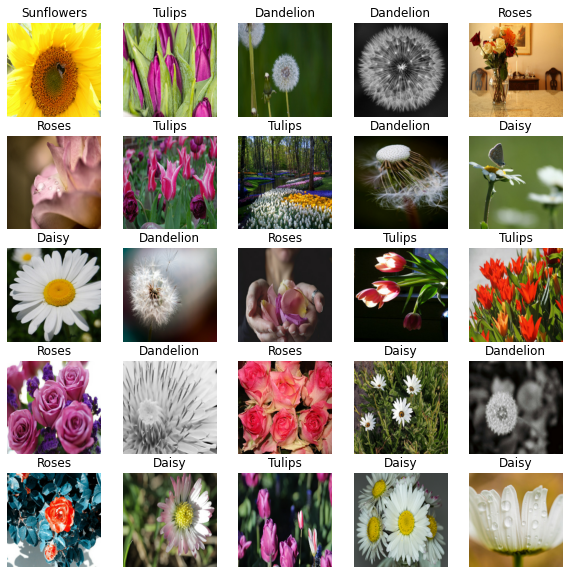

In [33]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Performance

In [34]:
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
    start = time.time()
    it = iter(ds)
    for i in range(steps):
        batch = next(it)
        if i%10 == 0:
            print('.', end='')
    print()
    end = time.time()
    
    duration = end - start
    print("{} batches: {} s".format(steps, duration))
    print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))

In [35]:
timeit(train_data_gen)

....................................................................................................
1000 batches: 133.88032865524292 s
239.01943 Images/s


In [ ]:
uncached_ds = prepare_for_training(labeled_ds, cache=False)
timeit(uncached_ds)

In [ ]:
filecache_ds = prepare_for_training(labeled_ds, cache="./flowers.tfcache")
timeit(filecache_ds)

## References
- https://www.tensorflow.org/tutorials/load_data/images#basic_methods_for_training